## Notebook

#### Import Julia packages

In [ ]:
using Gridap
using GridapMakie, CairoMakie, FileIO
using Gridap.FESpaces
using Gridap.ReferenceFEs
using Gridap.Arrays
using Gridap.Algebra
using Gridap.Geometry
using Gridap.Fields
using Gridap.CellData
using FillArrays
using Test
using InteractiveUtils

In [7]:
include("Julia_functions/solution_animation.jl")
include("Julia_functions/indicator_chi.jl")
include("Julia_functions/cost_func.jl")
include("Julia_functions/optimize.jl")
include("Julia_functions/solvers.jl")

AEsolver (generic function with 1 method)

In [ ]:
domain = (-1, 1, -1, 1)
partition = nx, ny = 50,50
model = CartesianDiscreteModel(domain, partition) |> simplexify

Ω = Triangulation(model)                                # make Triangulation
# fig = plot(Ω)
# wireframe!(Ω, color=:black)                             # Plot edges of each element
# scatter!(Ω, marker=:circle, markersize=20, color=:blue) # Plot mesh nodes
# display(fig)                                            # show plot


order = 1
reffe = ReferenceFE(lagrangian,Float64,order)
Testspace = TestFESpace(model,reffe,conformity=:H1)     # no Dirichlet (/ everything Neumann)

Trialspace = TrialFESpace(Testspace)                    # make trial space based on test space

degree = 2*order                                        # degree of the method used for approximating integrals over Ω                   
dΩ = Measure(Ω,degree)                                  # make the measure dΩ

Γ = BoundaryTriangulation(model)                        # triangulate the boundary ∂Ω
dΓ = Measure(Γ,degree)                                  # measure on Γ


# Varmekilden q er 1 i dette området og 0 ellers
Q(t) = χ(t, 0, 0.1)*1000 + χ(t, 0.2, 0.3)*1000
q_pos(x) = χ(x[1], -0.9, -0.85) * χ(x[2], 0, 0.20)


τ = 0.001
k = 1
h = 0.001
T_old = 20
T_out = 0
Time = 1
# To store the solution over time
solutions = []
a(T,ϕ) = ∫(T/τ*ϕ*1/Time + k*∇(ϕ)⊙∇(T))*dΩ - ∫(k*h*T*ϕ)*dΓ
for step in 1:1000
    
    l(ϕ) = ∫(q_pos*ϕ*Q(step*τ) + T_old/τ*ϕ*1/Time)*dΩ - ∫( k*h*T_out*ϕ)*dΓ 
    
    # Set up system matrix
    op = AffineFEOperator(a,l,Trialspace,Testspace)

    # Solve system matrix
    uh = solve(op) 
    
    # Store the solution
    if step%10 == 0
        push!(solutions, uh)
    end
    # Update T_old
    T_old = uh
end


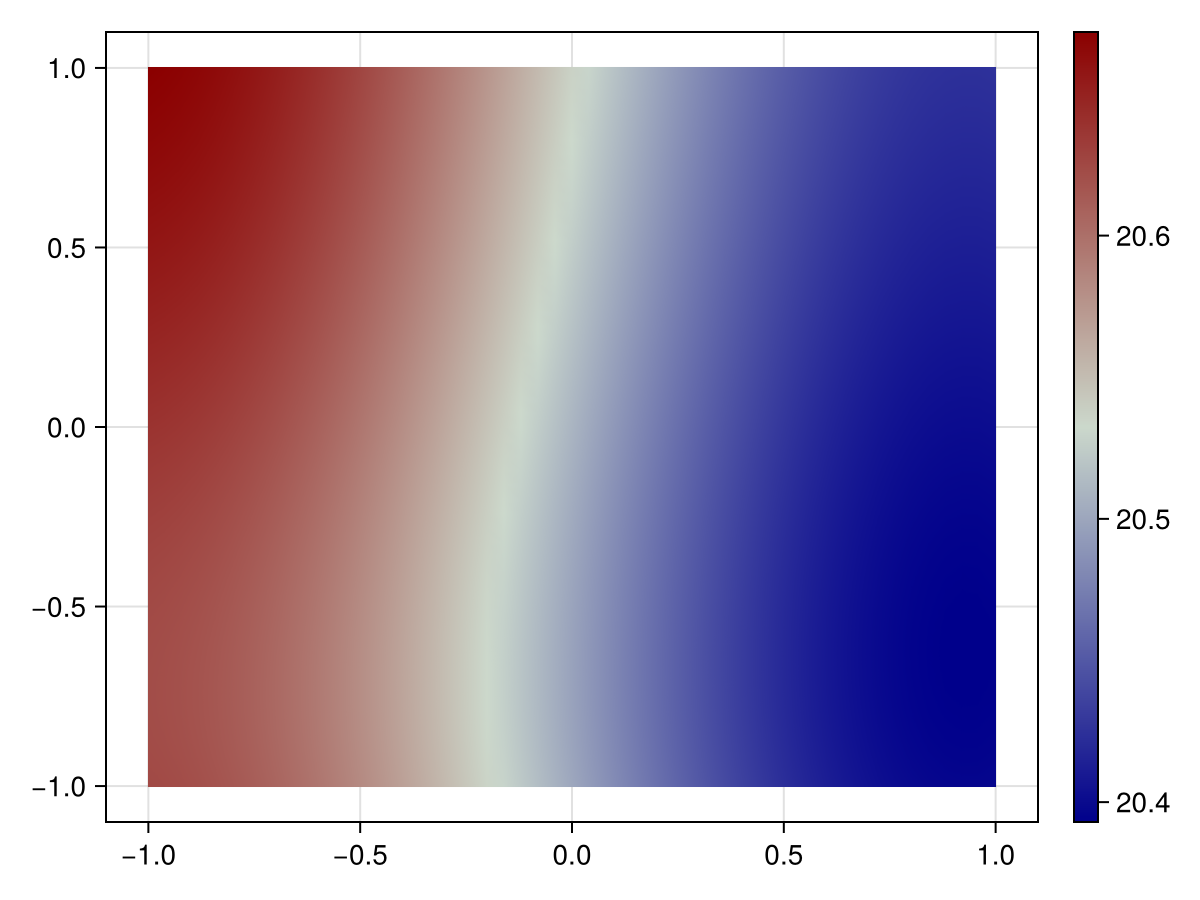

CairoMakie.Screen{IMAGE}


In [71]:
fig, ax, hm = plot(T_old)
Colorbar(fig[1,2], hm)
display(fig)

In [72]:
solution_animation(solutions, 30)


"animation.mp4"